# Analyse des données liées au COVID-19 en France
Données issues de l'Agance nationale de santé publique (Santé publique France).

## Importation des modules

In [217]:
import requests

In [218]:
from datetime import datetime

In [219]:
import pandas as pd 

In [220]:
import numpy as np 

In [221]:
import matplotlib.pyplot as plt 
%matplotlib inline

## Fonctions

In [222]:
# Récupération des fichiers .csv
def get_csv(url, file_name):
    req = requests.get(url) # Envoi de la requête

    if req.status_code == 200:
        print("LINK OK")
    else:
        print(req.status_code)

    url_content = req.content # Binary content
    csv_file = open(f'{file_name}.csv', 'wb')

    csv_file.write(url_content)
    csv_file.close()

    now = datetime.now()
    when = now.strftime("%d/%m/%Y à %H:%M:%S")
    print("Dernière mise à jour du CSV le", when)

    return pd.read_csv(f'{file_name}.csv', sep=";")

In [223]:
# Fonction calculant les variations de valeurs dans une série sous la forme d'un plot.bar à deux barres
# mode="day" : Variation entre hier et aujourd'hui
# mode="week" : Variation entre les 7 derniers jours et les 7 précédents
# absolute=True : Affiche la valeur absolue sur le graph
# absolute=False : Affiche la valeur avec l'opérateur +/- en préfixe sur le graph

def vario(series, mode="day", title="", grid=False, absolute=True):
    if mode == "day":
        last = series[len(series)-1]
        b_last = series[len(series)-2]
        diff = last - b_last
        perc = round(((last/b_last)*100)-100, 2)

    if mode == "week":
        last_week = []
        b_last_week = []
        i = len(series)-1

        while i > (len(series)-1) - 7:
            last_week.append(series[i])
            i-=1

        while i > (len(series)-1) - 14:
            b_last_week.append(series[i])
            i-=1
        
        last = sum(last_week)
        b_last = sum(b_last_week)
        diff = lw_sum - blw_sum
        perc = round(((lw_sum/blw_sum)*100)-100, 2)

    if last > b_last: # Variation +
        if mode == "day":
            print(f"Variation journalière = +{diff} [{perc}%] (Auj. : {last}, hier : {b_last})")
        else :
            print(f"Variation hébdomadaire = +{diff} [{perc}%] (Cette sem. : {last}, Sem. der. : {b_last})")
        color = ["lime", "coral"]

    elif last == b_last: # No variation
        if mode == "day":
            print(f"Variation journalière = +{diff} [{perc}%] (Auj. : {last}, hier : {b_last})")
        else :
            print(f"Variation hébdomadaire = +{diff} [{perc}%] (Cette sem. : {last}, Sem. der. : {b_last})")
        color = ["b", "b"]

    else : # Variation -
        if mode == "day":
            print(f"Variation journalière = {diff} [{perc}%] (Auj. : {last}, hier : {b_last})")
        else :
            print(f"Variation hébdomadaire = {diff} [{perc}%] (Cette sem. : {last}, Sem. der. : {b_last})")
        color = ["coral", "lime"]
    
    if mode == "day":
        df = pd.DataFrame({'jour':['Hier.', 'Auj.'], 'y':[b_last, last]})
        ax = df.plot.bar(x='jour', y='y', rot=0, color=color, legend=False, title = f"{title}\n ({when})")
    else:
        df = pd.DataFrame({'semaine':['Sem. der.', 'Cette sem.'], 'y':[b_last, last]})
        ax = df.plot.bar(x='semaine', y='y', rot=0, color=color, legend=False, title = f"{title}\n ({when})")

    x_offset = -0.1

    for p in ax.patches:
        b = p.get_bbox()
        if absolute:
            val = "{:.0f}".format(b.y1)
        else :
            val = "{:+.0f}".format(b.y1)     
        ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 - (b.y1/10)))
    
    return ax

## Récupération des fichiers .csv

### Données hospitalières cumulées
Données cumulées depuis le début des mesures en mars 2020.
3 nouvelles entrées par jour et par département

In [224]:
# Récupération du fichier .csv à partir d'une URL stable
url = "https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7"
cov = get_csv(url, "cov")

LINK OK
Dernière mise à jour du CSV le 24/11/2020 à 16:05:28


### Nouvelles données hospitalières
Variations journalières des données hospitalières

In [225]:
# Récupération du fichier .csv à partir d'une URL stable
url = "https://www.data.gouv.fr/fr/datasets/r/6fadff46-9efd-4c53-942a-54aca783c30c"
covn = get_csv(url, "covn")

LINK OK
Dernière mise à jour du CSV le 24/11/2020 à 16:05:28


## Exploration des données

### Explorations des données hospitalières cumulées
cov.csv

In [226]:
# Dimensions du dataset (lignes, colonnes)
cov.shape

(76053, 7)

In [227]:
# Affichage des premières lignes
cov.head()

,dep,sexe,jour,hosp,rea,rad,dc
0,01,0,2020-03-18,2,0,1,0
1,01,1,2020-03-18,1,0,1,0
2,01,2,2020-03-18,1,0,0,0
3,02,0,2020-03-18,41,10,18,11
4,02,1,2020-03-18,19,4,11,6


In [228]:
# Affichage des dernières lignes
cov.tail()

,dep,sexe,jour,hosp,rea,rad,dc
76048,974,1,2020-11-23,47,8,295,20
76049,974,2,2020-11-23,40,7,298,24
76050,976,0,2020-11-23,11,4,505,35
76051,976,1,2020-11-23,7,2,242,21
76052,976,2,2020-11-23,4,2,257,14


In [229]:
# Description générale du dataset
cov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76053 entries, 0 to 76052
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dep     76053 non-null  object
 1   sexe    76053 non-null  int64 
 2   jour    76053 non-null  object
 3   hosp    76053 non-null  int64 
 4   rea     76053 non-null  int64 
 5   rad     76053 non-null  int64 
 6   dc      76053 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 4.1+ MB


Informations sur les colonnes :

dep = Département (type 'str' et non 'int' car dep. Corse = 2A et 2B)

sexe = 0 : h/f | 1 : h | 2 : f

jour = Date de notification

hosp = Nombre d'hospitalisations

rea = Nombre de patients en réanimation

rad = Nombre de personnes retournées à domicile

dc = Nombre de décès en milieu hospitalier


### Exploration des nouvelles données hospitalières
covn.csv

In [230]:
covn.shape

(25250, 6)

In [231]:
covn.head()

,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad
0,01,2020-03-19,1,0,0,0
1,01,2020-03-20,0,0,0,1
2,01,2020-03-21,3,0,0,0
3,01,2020-03-22,3,1,0,1
4,01,2020-03-23,14,1,0,5


In [232]:
covn.tail()

,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad
25245,976,2020-11-19,1,1,0,2
25246,976,2020-11-20,1,0,0,0
25247,976,2020-11-21,1,0,0,2
25248,976,2020-11-22,0,0,0,0
25249,976,2020-11-23,1,0,1,0


In [233]:
covn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25250 entries, 0 to 25249
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   dep         25250 non-null  object
 1   jour        25250 non-null  object
 2   incid_hosp  25250 non-null  int64 
 3   incid_rea   25250 non-null  int64 
 4   incid_dc    25250 non-null  int64 
 5   incid_rad   25250 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.2+ MB


Informations sur les colonnes :

dep = département (type 'str' et non 'int' car dep. Corse = 2A et 2B)

jour = Date de notification

incid_hosp = Nombre quotidien de personnes nouvellement hospitalisées

incid_rea = Nombre quotidien de nouvelles admissions en réanimation

incid_dc = Nombre quotidien de personnes nouvellement décédées

incid_rad = Nombre quotidien de nouveaux retours à domicile

## Visualisation

### Tout le territoire

#### Réanimations

In [234]:
cov_0 = cov.loc[cov['sexe'] == 0]
cov_rea = cov_0.groupby("jour").rea.sum()

Variation journalière = -53 [-1.18%] (Auj. : 4438, hier : 4491)


<AxesSubplot:title={'center':'Nombres de personnes en réanimation ou en soins intensifs\n (24/11/2020 à 14:14:22)'}, xlabel='jour'>

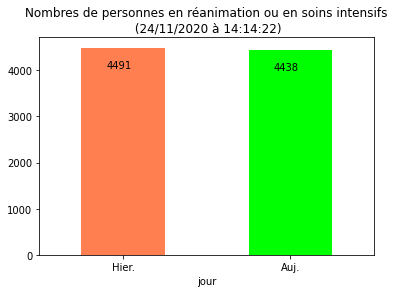

In [235]:
# Variations jour
vario(cov_rea, title="Nombres de personnes en réanimation ou en soins intensifs")

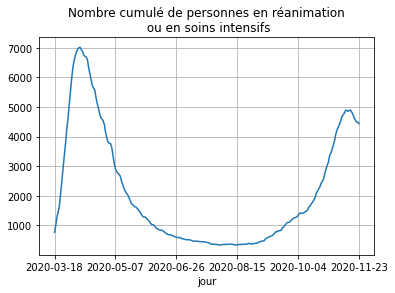

In [236]:
# Réanimations total
rea_graph = cov_rea.plot(grid=True, title="Nombre cumulé de personnes en réanimation\n ou en soins intensifs")

<AxesSubplot:title={'center':'Nombre quotidien de nouvelles admissions en réanimation'}, xlabel='jour'>

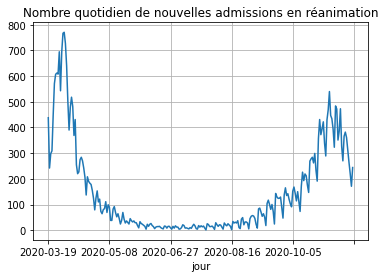

In [237]:
# Nouvelles réanimations
covn_rea = covn.groupby("jour").incid_rea.sum()
covn_rea.plot(title="Nombre quotidien de nouvelles admissions en réanimation", grid=True)

Variation journalière = +73 [42.69%] (Auj. : 244, hier : 171)


<AxesSubplot:title={'center':'Nouvelles admissions en réanimation\n (24/11/2020 à 14:14:22)'}, xlabel='jour'>

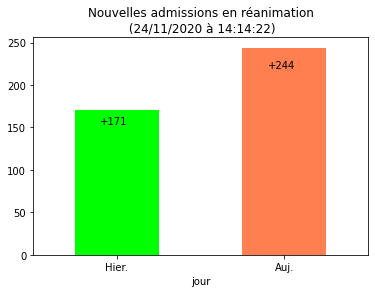

In [238]:
# Variation nouvelles admissions en réanimation
vario(covn_rea, title="Nouvelles admissions en réanimation", absolute=False)

#### Hospitalisations

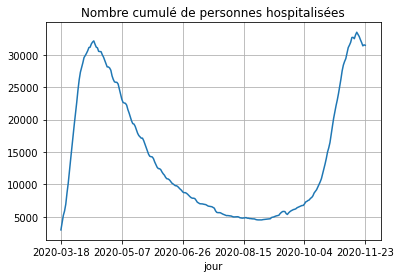

In [239]:
# Hospitalisations
hosp_graph = hosp_cov.plot(grid=True, title="Nombre cumulé de personnes hospitalisées")

<AxesSubplot:title={'center':'Nouvelles hospitalisations'}, xlabel='jour'>

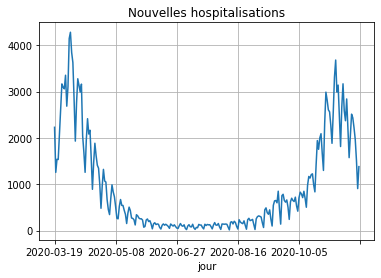

In [240]:
covn_hosp = covn.groupby("jour").incid_hosp.sum()
covn_hosp.plot(title="Nouvelles hospitalisations", grid=True)

Variation journalière = +474 [52.32%] (Auj. : 1380, hier : 906)


<AxesSubplot:title={'center':'Nouvelles hospitalisations\n (24/11/2020 à 14:14:22)'}, xlabel='jour'>

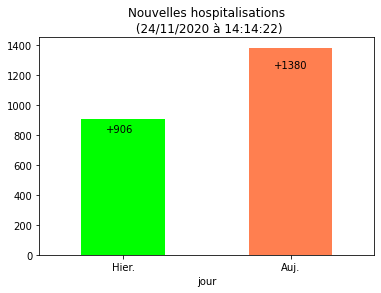

In [241]:
vario(covn_hosp, title="Nouvelles hospitalisations", absolute=False)

#### Décès

<AxesSubplot:title={'center':'Nombre de décès cumulé en milieu hospitalier'}, xlabel='jour'>

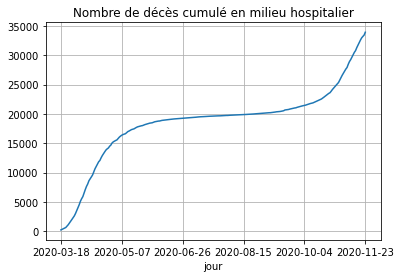

In [242]:
cov_dc.plot(grid=True, title="Nombre de décès cumulé en milieu hospitalier")

<AxesSubplot:title={'center':'Nouveaux décès'}, xlabel='jour'>

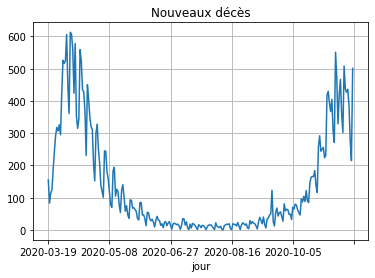

In [243]:
covn_dc = covn.groupby("jour").incid_dc.sum()
covn_dc.plot(title="Nouveaux décès", grid=True)

Variation journalière = +286 [133.02%] (Auj. : 501, hier : 215)


<AxesSubplot:title={'center':'Nouveaux décès\n (24/11/2020 à 14:14:22)'}, xlabel='jour'>

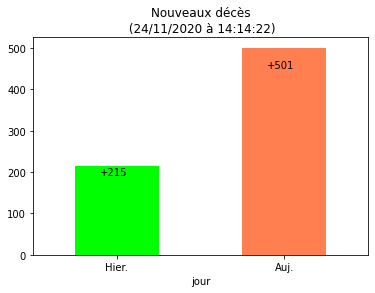

In [244]:
vario(covn_dc, title="Nouveaux décès", absolute=False)

Variation hébdomadaire = -1712 [-5.05%] (Cette sem. : 2678, Sem. der. : 2855)


<AxesSubplot:title={'center':'Weekly\n (24/11/2020 à 14:14:22)'}, xlabel='semaine'>

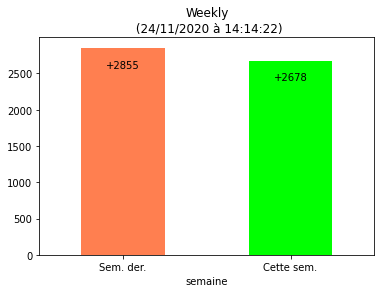

In [245]:
vario(covn_dc, mode="week", title="Weekly", absolute=False)

#### Retours à domicile

<AxesSubplot:title={'center':'Nouveaux retours à domicile'}, xlabel='jour'>

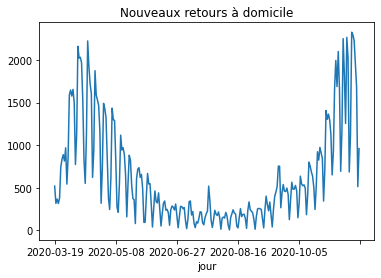

In [246]:
covn_rad = covn.groupby("jour").incid_rad.sum()
covn_rad.plot(title="Nouveaux retours à domicile")

#### Données croisées

<class 'matplotlib.axes._subplots.AxesSubplot'>


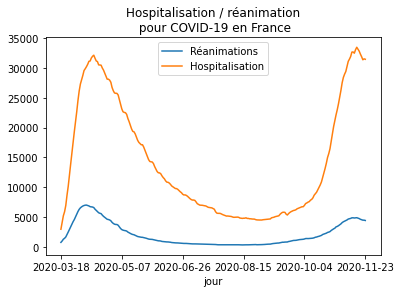

In [247]:
cov_rea.to_frame()
hosp_cov.to_frame()
rea_graph = cov_rea.plot(x="jour", y="rea")
hosp_graph = hosp_cov.plot(x="jour", y="hosp", title="Hospitalisation / réanimation\n pour COVID-19 en France")
hosp_graph.legend(["Réanimations", "Hospitalisation"])
print(type(hosp_graph))

### Par département

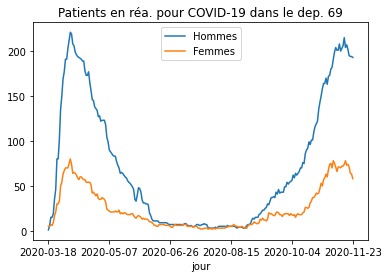

In [248]:
dep = "69" # Changer le département
cov_dep = cov.loc[cov['dep'] == dep]

cov_dep_0 = cov_dep.loc[cov_dep['sexe'] == 0] # Just H/F
cov_dep_1 = cov_dep.loc[cov_dep['sexe'] == 1] # Just H
cov_dep_2 = cov_dep.loc[cov_dep['sexe'] == 2] # Just F

title = f"Patients en réa. pour COVID-19 dans le dep. {dep}"

rea_1 = cov_dep_1.plot(x="jour", y="rea")
rea_2 = cov_dep_2.plot(x="jour", y="rea", ax=rea_1, grid=False, title = title)
rea_2.legend(["Hommes", "Femmes"])

<AxesSubplot:title={'center':'Nouvelles entrées en réanimation\n dans le département 69'}, xlabel='jour'>

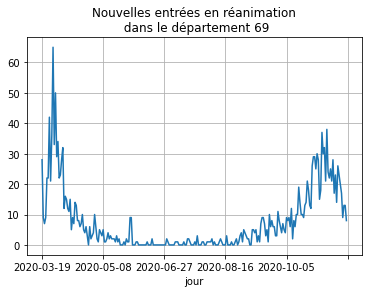

In [249]:
dep = "69"
covnDep = covn.loc[covn['dep'] == dep]
covnDep_rea = covnDep.groupby("jour").incid_rea.sum()
covnDep_rea.plot(title=f"Nouvelles entrées en réanimation\n dans le département {dep}", grid=True)

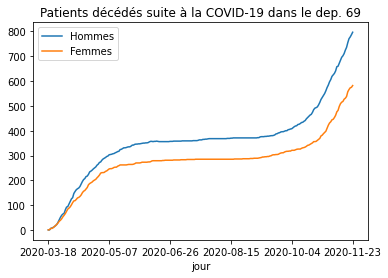

In [250]:
dep = "69"

cov_dep = cov.loc[cov['dep'] == dep]

cov_dep_1 = cov_dep.loc[cov_dep['sexe'] == 1] # Just H
cov_dep_2 = cov_dep.loc[cov_dep['sexe'] == 2] # Just F

title = f"Patients décédés suite à la COVID-19 dans le dep. {dep}"

dc_1 = cov_dep_1.plot(x="jour", y="dc")
dc_2 = cov_dep_2.plot(x="jour", y="dc", ax=dc_1, grid=False, title = title)
dc_2.legend(["Hommes", "Femmes"])